# NLP & Sentiment Analysis for Financial News
By: Joshua Jackson<br>
Date: June 26 2020

In [1]:
#import basic packages for use in the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#import custom scripts to simplify model processing and vectorization
#install with pip install -e financialTextProcessing
from financialTextProcessing.loadStockInfo import loadStockInfo as loadStock
import financialTextProcessing.textProcessing as tp
from financialTextProcessing.createWord2Vec import word2vec
from financialTextProcessing.modeling import modeling
import financialTextProcessing.plotBacktrade as plotBt 

In [3]:
#import sklearn packages
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [4]:
#import spacy
import spacy
from spacy.pipeline import EntityRecognizer
from spacy.tokens import Doc
from spacy.pipeline import EntityRuler

## Data Cleaning

Using my scripts I load in my stock data csvs supplied from Kaggle

In [5]:
#load stock info
stock_info = loadStock("../data/stock_info/stocks/", "../data/stock_info/symbols_valid_meta.csv", DEBUG=True)
#load stock historical data from csvs
stock_df = stock_info.loadStockDf()

In [6]:
#view stock df
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Name
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300.0,A,"Agilent Technologies, Inc. Common Stock"
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100.0,A,"Agilent Technologies, Inc. Common Stock"
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800.0,A,"Agilent Technologies, Inc. Common Stock"
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600.0,A,"Agilent Technologies, Inc. Common Stock"
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200.0,A,"Agilent Technologies, Inc. Common Stock"


In [7]:
#rename stock_df columns
stock_df.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'symbol', 'name']

In [8]:
stock_df.head()

,date,open,high,low,close,adj_close,volume,symbol,name
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300.0,A,"Agilent Technologies, Inc. Common Stock"
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100.0,A,"Agilent Technologies, Inc. Common Stock"
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800.0,A,"Agilent Technologies, Inc. Common Stock"
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600.0,A,"Agilent Technologies, Inc. Common Stock"
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200.0,A,"Agilent Technologies, Inc. Common Stock"


In [9]:
#get list of comapny symbols and names to use later for NLP rules
list_of_stock_symbols = np.unique(stock_df['symbol'])
list_of_comp_names = np.unique(stock_df['name'])

In [10]:
list_of_stock_symbols

array(['A', 'AA', 'AACG', ..., 'ZYME', 'ZYNE', 'ZYXI'], dtype=object)

In [11]:
list_of_comp_names

array(['1-800-FLOWERS.COM, Inc. - Class A Common Stock',
       '10x Genomics, Inc. - Common Stock',
       '111, Inc. - American Depositary Shares', ...,
       'uniQure N.V. - Ordinary Shares',
       'vTv Therapeutics Inc. - Class A Common Stock',
       'voxeljet AG American Depositary Shares, each representing one-fifth of an ordinary share/'],
      dtype=object)

In [12]:
stock_meta_df = stock_info.loadStockMetaDf()

Load news data frame from csv file
- original data was received use an API, the process of this is in loadArticles script

In [13]:
#load news data from csv
news_df = pd.read_csv("../data/news/final_news_sent.csv")
news_df

,ticker,title,sentiment,date
0,FB,"By Refusing to Act, Is Zuckerberg Hurting Face...",Neutral,"Sat, 06 Jun 2020 12:23:00 -0400"
1,FB,Zuckerberg: Facebook will review policies afte...,Neutral,"Sat, 06 Jun 2020 00:24:13 -0400"
2,FB,"Facebook, Instagram Take Down Trump George Flo...",Neutral,"Fri, 05 Jun 2020 23:50:21 -0400"
3,FB,"After Employee Backlash Over Trump Posts, Zuck...",Neutral,"Fri, 05 Jun 2020 22:36:29 -0400"
4,FB,Facebook's Zuckerberg promises a review of con...,Neutral,"Fri, 05 Jun 2020 20:23:01 -0400"
...,...,...,...,...
291208,ZTS,Will Boeing go lower? #AskHalftime,Neutral,"Wed, 12 Feb 2020 13:48:26 -0500"
291209,ZTS,Zoetis (ZTS) to Report Q4 Earnings: What's in ...,Neutral,"Mon, 10 Feb 2020 09:25:00 -0500"
291210,ZTS,Zoetis (ZTS) Earnings Expected to Grow: Should...,Positive,"Thu, 06 Feb 2020 12:31:08 -0500"
291211,ZTS,Zoetis Inc. (ZTS) CEO Kristin Peck on Q4 2019 ...,Neutral,"Thu, 13 Feb 2020 15:30:46 -0500"


In [14]:
#check types and fix if possible
news_df.dtypes

ticker       object
title        object
sentiment    object
date         object
dtype: object

In [15]:
#convert date to datetime object
news_df['date'] = pd.to_datetime(pd.to_datetime(news_df['date'], utc=True).dt.date)

## Data Anaysis

In [16]:
stock_df.isna().sum()

date           0
open         649
high         649
low          649
close        649
adj_close    649
volume       649
symbol         0
name           0
dtype: int64

As we see there are some NaN values but considering the number of rows it is fairly insignificant and as such will just be dropped.

In [17]:
#check to see if any rows are NaN
stock_df.dropna(inplace=True)

In [18]:
stock_df.isna().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
symbol       0
name         0
dtype: int64

In [19]:
#check for any NaN values in news_df
news_df.isna().sum()

ticker       0
title        0
sentiment    0
date         0
dtype: int64

Now to do some EDA we will check to see the distribution of News Data, I am not very concerned about the stock data, as at this point my focus is on text analysis and sentiment predictions.

In [20]:
#check distribution of News Articles and their Sentiment
plt.figure(figsize=(10,7))
sns.barplot(x=news_df['sentiment'].value_counts().index, y=news_df['sentiment'].value_counts())
plt.xlabel("Sentiment (Positive - Neutral - Negative)", size=14)
plt.ylabel("Number of Headlines", size=14)
plt.title("Count of Headlines by Sentiment", size=18)
plt.show()

As we can see their is a serious distribution issue between Positive and Negative which we are more concerned about. So I will be sure to resample based on the positive and negative sentiment to create more equal distribution.

In [21]:
news_df.groupby(['date', 'sentiment']).count()

ticker  title
date       sentiment               
2001-11-30 Negative        1      1
           Neutral         1      1
           Positive        1      1
2016-02-27 Positive        4      4
2016-12-23 Neutral         1      1
...                      ...    ...
2020-06-09 Neutral       154    154
           Positive      190    190
2020-06-10 Negative       69     69
           Neutral       136    136
           Positive      179    179

[1766 rows x 2 columns]

As we can see we have a huge gap between a few news articles so we will remove everything before 2016

In [22]:
news_df.dtypes

ticker               object
title                object
sentiment            object
date         datetime64[ns]
dtype: object

In [23]:
news_df = news_df[news_df['date'] > '2016-01-01']

In [24]:
#get sentiment and date values
grouped_sent_df = news_df.groupby(['date', 'sentiment']).count()['ticker'].to_frame().reset_index()

In [25]:
grouped_sent_df.query("sentiment == 'Positive'")['date']

0      2016-02-27
2      2016-12-23
3      2016-12-24
4      2016-12-27
6      2016-12-28
          ...    
1750   2020-06-06
1753   2020-06-07
1756   2020-06-08
1759   2020-06-09
1762   2020-06-10
Name: date, Length: 504, dtype: datetime64[ns]

In [26]:
#Check distribution by date
plt.figure(figsize=(12,10))
plt.scatter(grouped_sent_df.query("sentiment == 'Positive'")['date'], grouped_sent_df.query("sentiment == 'Positive'")['ticker'], label='Positive Sentiment')
plt.scatter(grouped_sent_df.query("sentiment == 'Negative'")['date'], grouped_sent_df.query("sentiment == 'Negative'")['ticker'], label='Negative Sentiment')
plt.scatter(grouped_sent_df.query("sentiment == 'Neutral'")['date'], grouped_sent_df.query("sentiment == 'Neutral'")['ticker'], label='Neutral Sentiment')
plt.xlabel("Date", size=14)
plt.ylabel("Number of Articles", size=14)
plt.title("News Sentiment by Date", size=18)
plt.legend()
plt.show()
plt.savefig("news_sentiment_by_date.png")

We can see there is clearly a severe distribution issue over time. There is no point in analyzing the articles before 2018-01 as there are so few. They will be dropped.

In [27]:
#drop all rows which are from before 2018 
news_df = news_df[news_df['date'] > '2018-01-01']
news_df = news_df.reset_index(drop=True)

Now that everything is clean we can begin to process the text data, we will begin with one hot encoding the sentiment to create a vector for later use. As well, we will label encode for use with CountVectorizer and TF-IDF Vectorizer.

## Text Processing & Cleaning

In [28]:
#create one hot encoder and label encoder
onehotEncoder = OneHotEncoder()
labelEncoder = LabelEncoder()

In [29]:
#create label encoding for logistic regression and decision tree
news_df['sentiment_value'] = labelEncoder.fit_transform(news_df['sentiment'])

In [30]:
#create one hot encoding and add to news data frame for neural network
news_df = news_df.join(pd.DataFrame(onehotEncoder.fit_transform(news_df[['sentiment_value']]).toarray(), columns=['is_negative', 'is_neutral', 'is_positive']))

In [31]:
news_df.head()

,ticker,title,sentiment,date,sentiment_value,is_negative,is_neutral,is_positive
0,FB,"By Refusing to Act, Is Zuckerberg Hurting Face...",Neutral,2020-06-06,1,0.0,1.0,0.0
1,FB,Zuckerberg: Facebook will review policies afte...,Neutral,2020-06-06,1,0.0,1.0,0.0
2,FB,"Facebook, Instagram Take Down Trump George Flo...",Neutral,2020-06-06,1,0.0,1.0,0.0
3,FB,"After Employee Backlash Over Trump Posts, Zuck...",Neutral,2020-06-06,1,0.0,1.0,0.0
4,FB,Facebook's Zuckerberg promises a review of con...,Neutral,2020-06-06,1,0.0,1.0,0.0


I will perform upsampling now before we move onto CountVectorizer or TF-IDF so we can perform that with balanced data

In [32]:
#set X and y for resample
X = news_df.drop(columns=['is_negative'])
y = news_df['is_negative']

In [33]:
#now we will resample to blance news data set
print(f"Number of Negative Reviews Before: {X[y==1].shape}")

#upsample negative reviews to try and compensate for imbalance
X_upsample, y_upsample = resample(X[y == 1], y[y == 1], replace=True, n_samples=X[X['is_positive'] == 1].shape[0], random_state=123)

print(f"Number of Negative Reviews Before: {X_upsample.shape}")

Number of Negative Reviews Before: (49086, 7)
Number of Negative Reviews Before: (133711, 7)


In [34]:
#combine upsample with original for balanced set
X_balanced = np.vstack((X[y == 0], X_upsample))
y_balanced = np.hstack((y[y == 0], y_upsample))

In [35]:
x_df = pd.DataFrame(X_balanced, columns=['ticker', 'title','sentiment', 'date', 'sentiment_value', 'is_neutral', 'is_positive'])
y_df = pd.DataFrame(y_balanced, columns=['is_negative'])

In [217]:
#join balanced df and check shape and head
balanced_news_df = x_df.join(y_df)
print(f"Balanced News DF Shape: {balanced_news_df.shape}")
balanced_news_df.head()

Balanced News DF Shape: (375811, 8)


,ticker,title,sentiment,date,sentiment_value,is_neutral,is_positive,is_negative
0,FB,"By Refusing to Act, Is Zuckerberg Hurting Face...",Neutral,2020-06-06,1,1,0,0.0
1,FB,Zuckerberg: Facebook will review policies afte...,Neutral,2020-06-06,1,1,0,0.0
2,FB,"Facebook, Instagram Take Down Trump George Flo...",Neutral,2020-06-06,1,1,0,0.0
3,FB,"After Employee Backlash Over Trump Posts, Zuck...",Neutral,2020-06-06,1,1,0,0.0
4,FB,Facebook's Zuckerberg promises a review of con...,Neutral,2020-06-06,1,1,0,0.0


In [218]:
#check types
balanced_news_df.dtypes

ticker                     object
title                      object
sentiment                  object
date               datetime64[ns]
sentiment_value            object
is_neutral                 object
is_positive                object
is_negative               float64
dtype: object

In [219]:
#adjust types
balanced_news_df = balanced_news_df.astype({'sentiment_value': 'int', 'is_neutral': 'float', 'is_positive': 'float', 'is_negative': 'float'})

Now that we have a balanced dataset we will move to tokenization, lemmatization and removal of stop words for Bag-Of-Words approach and TF-IDF approach.

In [214]:
stock_meta_df = stock_info.loadStockMetaDf()

In [41]:
#prep pattern for Spacy NLP
stock_meta_df['Tag'] = 'ORG'

In [42]:
#create spacy nlp object with added rules to use when tokenizing
nlp = spacy.load("en_core_web_lg")
ruler = EntityRuler(nlp)

#creating apattern for entity ruler
temp_df1 = stock_meta_df.query('Symbol != "A"')[['Tag', 'Symbol']]
temp_df1.columns = ['label', 'pattern']
temp_df2 = stock_meta_df[['Tag', 'Name']]
temp_df2.columns = ['label', 'pattern']

temp_df = pd.concat([temp_df1, temp_df2])

#set patterns
patterns = temp_df.to_dict('records')
#add patterns to ruler
ruler.add_patterns(patterns)
#add ruler to nlp
nlp.add_pipe(ruler)

textProcessing = tp(nlp)

In [ ]:
#positive negative wordcloud based on titles
#wordcloud
from wordcloud import WordCloud, STOPWORDS

for line in balanced_news_df[balanced_news_df['sentiment_value'] == 2]['title']:
    pos_text += ' '.join(line)
    
for line in balanced_news_df[balanced_news_df['sentiment_value'] == 0]['title']:
    neg_text += ' '.join(line)

In [ ]:
#postive word cloud
wc_pos = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(pos_text)

In [ ]:
#negative word cloud
wc_neg = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(neg_text)

In [43]:
#train validate test split using my script with textProcessing object
#for this split we are using sentiment value which 0 - Negative, 1 - Neutral, 2 - Positive
X_remainder, X_test, y_remainder, y_test = textProcessing.trainTestSplit(balanced_news_df['title'], balanced_news_df['sentiment_value'])
X_train, X_validate, y_train, y_validate = textProcessing.trainTestSplit(X_remainder, y_remainder, testSize=0.3)

## CountVectorizer

CountVectorizer using max_features of 1000, which still takes a very long time to run.<br>
If you have the data stored then not too worry.<br>
<b>DO NOT RUN UNLESS YOU HAVE LOTS OF TIME</b>

In [ ]:
#check if the premade csv files are saved otherwise create new dataframes
if os.path.exists('cvData/CountVectorizerTrainingData.csv'):
    X_train_cv_df = pd.read_csv('cvData/CountVectorizerTrainingData.csv')
    if os.path.exists('cvData/CountVectorizerValidationData.csv'):
        X_validation_cv_df = pd.read_csv('cvData/CountVectorizerValidationData.csv')
else:
    #count vectorize using train and validate
    X_train_cv_df, X_validate_cv_df = textProcessing.countVectorize(X_train, X_validate, c=0.01)

In [45]:
#count vectorize using train and validate
X_train_cv_df, X_validate_cv_df = textProcessing.countVectorize(X_train, X_validate, c=0.01)

/Users/jjackson/opt/anaconda3/envs/BrainStationCapstone/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [52]:
X_train_cv_df.drop(columns=[''], inplace=True)
X_validate_cv_df.drop(columns=[''], inplace=True)

In [53]:
X_train_cv_df.to_csv("CountVectorizerTrainingData.csv", index=False)
X_validate_cv_df.to_csv("CountVectorizerValidationData.csv", index=False)

### CountVectorizer WordCount

In [56]:
y_train.reset_index(drop=True,inplace=True)

In [57]:
#get top positive and negative words for count vectorizer
positive_word_counts = np.array(np.sum(X_train_cv_df[y_train == 2], axis=0)).reshape((-1,))
negative_word_counts = np.array(np.sum(X_train_cv_df[y_train == 0], axis=0)).reshape((-1,))

words = np.array(X_train_cv_df.columns)
pos_words_df = pd.DataFrame({"word":words, "count":positive_word_counts})
neg_words_df = pd.DataFrame({"word":words, "count":negative_word_counts})

In [58]:
pos_words_df.sort_values(by="count", ascending=False).head(10)

,word,count
829,stock,28949
267,earning,13228
147,buy,12537
309,estimate,6149
27,3,5847
37,5,5637
831,stock buy,5627
106,beat,4801
753,revenue,3871
255,dividend,3548


In [59]:
neg_words_df.sort_values(by="count", ascending=False).head(10)

,word,count
267,earning,21164
829,stock,16220
724,report,9058
309,estimate,8572
235,decline,6051
753,revenue,5894
542,miss,5569
657,q1,5236
204,coronavirus,5140
334,fall,5010


## TF-IDF Vectorizer

In [60]:
#use tfidf transformer on countvecorized dataframes
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
tfidf.fit(X_train_cv_df)

TfidfTransformer()

In [61]:
X_train_tfidf = tfidf.transform(X_train_cv_df)
X_validate_tfidf = tfidf.transform(X_validate_cv_df)

In [62]:
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=X_train_cv_df.columns)
X_validate_tfidf_df = pd.DataFrame(X_validate_tfidf.toarray(), columns=X_validate_cv_df.columns)

### TF-IDF WordCount

In [63]:
#get top positive and negative words for tfidf vector
positive_word_counts = np.array(np.sum(X_train_tfidf_df[y_train == 2], axis=0)).reshape((-1,))
negative_word_counts = np.array(np.sum(X_train_tfidf_df[y_train == 0], axis=0)).reshape((-1,))

words = np.array(X_train_tfidf_df.columns)
pos_words_df = pd.DataFrame({"word":words, "count":positive_word_counts})
neg_words_df = pd.DataFrame({"word":words, "count":negative_word_counts})

In [64]:
pos_words_df.sort_values(by="count", ascending=False).head(10)

,word,count
829,stock,5629.228299
147,buy,3625.260497
267,earning,2375.367305
27,3,1977.223747
831,stock buy,1951.502070
37,5,1932.035064
106,beat,1506.740549
309,estimate,1492.727634
255,dividend,1301.847188
404,growth,1100.553835


In [65]:
neg_words_df.sort_values(by="count", ascending=False).head(10)

,word,count
267,earning,3684.391401
829,stock,3199.334131
724,report,2373.350828
334,fall,1823.275123
309,estimate,1822.447678
235,decline,1687.533102
542,miss,1605.034151
204,coronavirus,1597.649654
902,today,1593.129869
795,share,1453.473808


## Modeling

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [67]:
md = modeling(DEBUG=True)

### Logistic Regression

This is a GridSearchCV pipeline, which you <b>SHOULD NOT RUN IT TAKES A LONG TIME</b>

In [ ]:
#create pipeline for logistic regression
pipe = Pipeline([('model' , LogisticRegression())])

# Create param grid.
param_grid = [
{'model': [LogisticRegression(max_iter=1000, solver='saga')], 
 'model__C': [0.001, 0.01, 0.1, 1, 10, 100]},
{'model': [DecisionTreeClassifier()], 
 'model__max_depth': [1, 2, 5, 10, 15, 20, 25],
 'model__min_samples_leaf': [2, 10]}
]

In [ ]:
#create GridSearch for logistic regression
grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X_train_cv_df, y_train)

In [ ]:
#see best params for logistic regression CountVectorizer
fittedgrid.best_params_

#### CountVectorizer Logistic Regression Validation

In [68]:
#fit and build model using best params
lr_model_cv = md.logisticRegression(X_train_cv_df, y_train, c=0.01)

In [69]:
#classification report and confusion matrix on validation
y_pred_cv = lr_model_cv.predict(X_validate_cv_df)
print("Confusion Matrix CountVectorizer - Validation")
print(confusion_matrix(y_validate, y_pred_cv))
print("\nClassification Report CountVectorizer - Validation")
print(classification_report(y_validate, y_pred_cv))

Confusion Matrix CountVectorizer - Validation
[[25998  2863  3053]
 [ 4322 16491  5128]
 [ 2733  4277 25330]]

Classification Report CountVectorizer - Validation
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     31914
           1       0.70      0.64      0.67     25941
           2       0.76      0.78      0.77     32340

    accuracy                           0.75     90195
   macro avg       0.75      0.74      0.74     90195
weighted avg       0.75      0.75      0.75     90195



As we can see through the classification report, the accuracy isn't terrible. But Not good enough for determine a buying or selling point of a stock. There is too many chances of false positive or false negative outcomes. For the most part I am most concerned about the positive and negative classification, seeing as neutral will be treated as a 0 value.

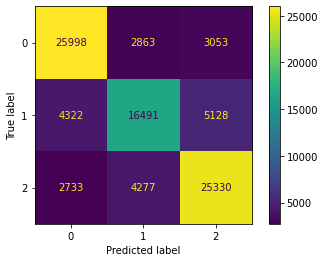

In [72]:
#display confusion matrix
%matplotlib inline
ConfusionMatrixDisplay(confusion_matrix(y_validate, y_pred_cv)).plot()

#### TF-IDF Logistic Regression Validation

In [73]:
#fit and build model
lr_model_tfidf = md.logisticRegression(X_train_tfidf_df, y_train, c=0.01)

In [74]:
#classification report on validation
y_pred_tfidf = lr_model_tfidf.predict(X_validate_tfidf_df)
print("Confusion Matrix TF-IDF - Validation")
print(confusion_matrix(y_validate, y_pred_tfidf))
print("\nClassification Report TF-IDF - Validation")
print(classification_report(y_validate, y_pred_tfidf))

Confusion Matrix TF-IDF - Validation
[[26478  2118  3318]
 [ 5421 15000  5520]
 [ 3448  3433 25459]]

Classification Report TF-IDF - Validation
              precision    recall  f1-score   support

           0       0.75      0.83      0.79     31914
           1       0.73      0.58      0.65     25941
           2       0.74      0.79      0.76     32340

    accuracy                           0.74     90195
   macro avg       0.74      0.73      0.73     90195
weighted avg       0.74      0.74      0.74     90195



We can see that TF-IDF vectorizer does a slightly better job at classifying each case correctly, but the difference is non-substantial. 

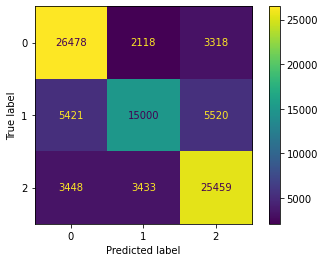

In [75]:
#display confusion matrix
%matplotlib inline
ConfusionMatrixDisplay(confusion_matrix(y_validate, y_pred_tfidf)).plot()

#### CountVectorizer Logistic Regression Full Data

In [ ]:
#fit on remainder and run on test set
if os.path.exists('data/CountVectorizerRemainderData.csv'):
    X_remainder_cv_df = pd.read_csv("data/CountVectorizerRemainderData.csv")
    if os.path.exists('data/CountVectorizerTestData.csv'):
        X_test_cv_df = pd.read_csv("data/CountVectorizerTestData.csv")
else:
    #count vectorize using train and validate
    X_remainder_cv_df, X_test_cv_df = textProcessing.countVectorize(X_remainder, X_test, c=0.01)

#### TF-IDF Logistic Regression Full Data

### DecisionTree

#### CountVectorizer Decision Tree Validation

In [88]:
#create decision tree model for countvectorizer
dt_model_cv = md.decisionTreeClassifier(X_train_cv_df, y_train, maxDepth=15)

In [89]:
#classification report on validation
y_pred_dt_cv = dt_model_cv.predict(X_validate_cv_df)
print("Confusion Matrix CountVectorizer DT - Validation")
print(confusion_matrix(y_validate, y_pred_dt_cv))
print("\nClassification Report CountVectorizer DT - Validation")
print(classification_report(y_validate, y_pred_dt_cv))

Confusion Matrix CountVectorizer DT - Validation
[[27734    92  4088]
 [15435  7238  3268]
 [14477   259 17604]]

Classification Report CountVectorizer DT - Validation
              precision    recall  f1-score   support

           0       0.48      0.87      0.62     31914
           1       0.95      0.28      0.43     25941
           2       0.71      0.54      0.61     32340

    accuracy                           0.58     90195
   macro avg       0.71      0.56      0.56     90195
weighted avg       0.70      0.58      0.56     90195



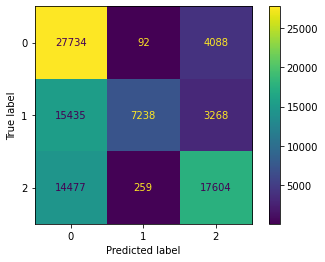

In [90]:
#display confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_validate, y_pred_dt_cv)).plot()

#### TF-IDF Vectorizer Decision Tree Validation

In [91]:
#create decision tree model for tfidf
dt_model_tfidf = md.decisionTreeClassifier(X_train_tfidf_df, y_train, maxDepth=15)

In [92]:
#classification report on validation
y_pred_dt_tfidf = dt_model_tfidf.predict(X_validate_tfidf_df)
print("Confusion Matrix TF-IDF DT - Validation")
print(confusion_matrix(y_validate, y_pred_dt_tfidf))
print("\nClassification Report TF-IDF DT - Validation")
print(classification_report(y_validate, y_pred_dt_tfidf))

Confusion Matrix TF-IDF DT - Validation
[[27884    96  3934]
 [16150  6928  2863]
 [15138   198 17004]]

Classification Report TF-IDF DT - Validation
              precision    recall  f1-score   support

           0       0.47      0.87      0.61     31914
           1       0.96      0.27      0.42     25941
           2       0.71      0.53      0.61     32340

    accuracy                           0.57     90195
   macro avg       0.71      0.56      0.55     90195
weighted avg       0.70      0.57      0.55     90195



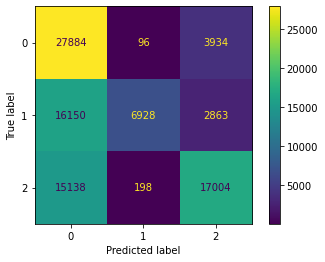

In [93]:
#display confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_validate, y_pred_dt_tfidf)).plot()

#### CountVectorizer Decision Tree Full Data

#### TF-IDF Decision Tree Full Data

## TensorFlow Tokenizing and Word Embedding

In [257]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Recall, Precision

Using tensorflow tokenizer I will fit on the titles, and then create text sequences. Padded to be over a specific length for the neural network.

In [160]:
import string
import os

<b>This takes a long time to run</b>

In [ ]:
if os.path.exist('data/cleaned_title_final_news.csv')
    balanced_news_df = pd.read_csv('data/cleaned_title_final_news.csv')

In [221]:
#create tokenized list for each line in balanced news to prepare for tensorflow tokenizer
for key, title in enumerate(balanced_news_df['title']):
    balanced_news_df.loc[key, 'title'] = ' '.join(textProcessing.tokenizeSpacy(title))
    print(key, end='\r')

In [222]:
#save newly pre tokenized titles in csv for later use as checkpoint
balanced_news_df.to_csv("cleaned_title_final_news.csv", index=False)

In [225]:
#tokenize with tensorflow on a pre tokenized and cleaned list from spacy
tk = Tokenizer(lower=True, filters=string.punctuation, split=' ')
#fit tokenizer on training titles on data set
tk.fit_on_texts(balanced_news_df['title'])

In [227]:
#len of tokens
print(f"Number of Tokens: {len(tk.word_index)}")

Number of Tokens: 45651


In [228]:
#set max_len of article headlines
max_len = 25
#get tokenized titles
tokenized_title = tk.texts_to_sequences(balanced_news_df['title'])
tokenized_title_X = pad_sequences(tokenized_title, maxlen=max_len)
#get size of vocab after stop word removal
vocab_size = len(tk.word_index) + 1

In [229]:
#split data for tensorflow tokenizer
X_remainder_tk, X_test_tk, y_remainder_tk, y_test_tk = train_test_split(tokenized_title_X,\
                                                                        balanced_news_df[['is_neutral', 'is_positive', 'is_negative']],\
                                                                        test_size = 0.2, random_state=1)
X_train_tk, X_validate_tk, y_train_tk, y_validate_tk = train_test_split(X_remainder_tk, y_remainder_tk, test_size=0.3, random_state=1)

In [230]:
#function to build embedding matrix
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

#### Custom Word Embeddings

for custom embeddings I used gensim to build a bi-gram tokenization of my data. The code for this is in the script `createWord2Vec.py`

In [233]:
#load model for custom trained models
filename = "../data/custom_embed_vector/too_large/bi-gram-model.txt"
embed_size_gensim = 250
max_features = tokenized_title_X.max() +1

#get embedding matrix
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(filename))
word_index = tk.word_index

nb_words = min(max_features, len(word_index))
embedding_matrix_gensim = np.zeros((nb_words+1, embed_size_gensim))

#create embedded word vectors
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix_gensim[i] = embedding_vector

In [234]:
#shape of custom embedding matrix
embedding_matrix_gensim.shape

(45652, 250)

#### Pre-Trained Word Embeddings

In [235]:
#load model for custom trained models
filename = '../data/custom_embed_vector/too_large/GoogleNews-vectors-negative300.txt'
embed_size_goog = 300
max_features = len(tk.word_index) + 1

#get embedding matrix
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(filename))
word_index = tk.word_index

nb_words = min(max_features, len(word_index))
embedding_matrix_goog = np.zeros((nb_words + 1, embed_size_goog))

#create embedded word vectors
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix_goog[i] = embedding_vector

In [236]:
#shape of google embedding matrix
embedding_matrix_goog.shape

(45652, 300)

### LSTM - RNN

Using tensorflow keras, I created a basic LSTM RNN model. In time I would like to make it more advanced but due to computational limitations, I couldn't produce a more advanced model at this time.

- I did create this model and the ability to build in a script as part of my package, but for display purpose I will write the code here a well
- There are two models one for the custom embeddings, and one for the pre-trained embeddings

In [237]:
#create callbacks for both models equal
my_callbacks = [
    #ensure that we dont overfit
    EarlyStopping(patience=3),
    #save models at checkpoints to make evauation later easier (not needed for demo)
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #logging (not needed for demo)
#     TensorBoard(log_dir='./logs')
]

#### Custom Model

In [238]:
#create model
model1 = Sequential()
model1.add(Embedding(vocab_size, embed_size_gensim, weights=[embedding_matrix_gensim], input_length=25, trainable=False))
model1.add(LSTM(200, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(100))
model1.add(Flatten())
model1.add(Dense(3, activation='softmax'))

#compile model
model1.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', Recall(), Precision()])

In [239]:
#see model summary
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 250)           11413000  
_________________________________________________________________
lstm_6 (LSTM)                (None, 25, 200)           360800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 200)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               120400    
_________________________________________________________________
flatten_3 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 11,894,503
Trainable params: 481,503
Non-trainable params: 11,413,000
____________________________________

In [240]:
#check to see if model file exists otherwise fit and train model
if os.path.exists('model/SimpleRNN_custom.h5'):
    model1 = load_model('model/SimpleRNN_custom.h5')
else:
    #fit model for evaluation
    model1.fit(X_train_tk, y_train_tk,
             batch_size=64,
             verbose=1,
             epochs=50,
             validation_data=(X_validate_tk, y_validate_tk),
             callbacks=my_callbacks)

Epoch 1/50
3289/3289 [==============================] - 297s 90ms/step - loss: 0.6911 - accuracy: 0.6842 - recall_2: 0.5647 - precision_2: 0.7852 - val_loss: 0.6239 - val_accuracy: 0.7184 - val_recall_2: 0.6026 - val_precision_2: 0.8199
Epoch 2/50
3289/3289 [==============================] - 321s 98ms/step - loss: 0.5923 - accuracy: 0.7380 - recall_2: 0.6495 - precision_2: 0.8156 - val_loss: 0.5856 - val_accuracy: 0.7421 - val_recall_2: 0.6666 - val_precision_2: 0.8068
Epoch 3/50
3289/3289 [==============================] - 319s 97ms/step - loss: 0.5436 - accuracy: 0.7622 - recall_2: 0.6880 - precision_2: 0.8280 - val_loss: 0.5271 - val_accuracy: 0.7688 - val_recall_2: 0.7062 - val_precision_2: 0.8294
Epoch 4/50
3289/3289 [==============================] - 383s 116ms/step - loss: 0.5023 - accuracy: 0.7818 - recall_2: 0.7201 - precision_2: 0.8389 - val_loss: 0.5006 - val_accuracy: 0.7828 - val_recall_2: 0.7214 - val_precision_2: 0.8383
Epoch 5/50
3289/3289 [=============================

In [250]:
#evaluate on test set
scores = model1.evaluate(X_test_tk, y_test_tk, batch_size=64)
print(f"Model Custom Embedding \nLoss: {round(scores[0], 2)}\nAccuracy: {round(scores[1], 2)}\nRecall: {round(scores[2], 2)}\nPercision: {round(scores[3], 2)}")

1175/1175 [==============================] - 25s 21ms/step - loss: 0.4348 - accuracy: 0.8494 - recall_2: 0.8385 - precision_2: 0.8616
Model Custom Embedding 
Loss: 0.43
Accuracy: 0.85
Recall: 0.84
Percision: 0.86


#### Pre-trained Model

In [251]:
#create model
model2 = Sequential()
model2.add(Embedding(vocab_size, embed_size_goog, weights=[embedding_matrix_goog], input_length=25, trainable=False))
model2.add(LSTM(200, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(100))
model2.add(Flatten())
model2.add(Dense(3, activation='softmax'))

#compile model
model2.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', Recall(), Precision()])

In [252]:
#see model summary
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 300)           13695600  
_________________________________________________________________
lstm_8 (LSTM)                (None, 25, 200)           400800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 25, 200)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               120400    
_________________________________________________________________
flatten_4 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 14,217,103
Trainable params: 521,503
Non-trainable params: 13,695,600
____________________________________

In [255]:
#check if fitted model already exists otherwise train
if os.path.exists('model/SimpleRNN_pretrain.h5'):
    model2 = load_model('model/SimpleRNN_pretrain.h5')
else:
    #fit model for evaluation
    model2.fit(X_train_tk, y_train_tk,
             batch_size=64,
             verbose=1,
             epochs=50,
             validation_data=(X_validate_tk, y_validate_tk),
             callbacks=my_callbacks)

Epoch 1/50
3289/3289 [==============================] - 298s 91ms/step - loss: 0.5373 - accuracy: 0.7718 - recall_3: 0.7152 - precision_3: 0.8187 - val_loss: 0.4632 - val_accuracy: 0.8043 - val_recall_3: 0.7605 - val_precision_3: 0.8433
Epoch 2/50
3289/3289 [==============================] - 335s 102ms/step - loss: 0.4381 - accuracy: 0.8180 - recall_3: 0.7829 - precision_3: 0.8484 - val_loss: 0.4242 - val_accuracy: 0.8230 - val_recall_3: 0.7977 - val_precision_3: 0.8475
Epoch 3/50
3289/3289 [==============================] - 418s 127ms/step - loss: 0.3775 - accuracy: 0.8452 - recall_3: 0.8200 - precision_3: 0.8682 - val_loss: 0.3834 - val_accuracy: 0.8432 - val_recall_3: 0.8229 - val_precision_3: 0.8624
Epoch 4/50
3289/3289 [==============================] - 359s 109ms/step - loss: 0.3227 - accuracy: 0.8686 - recall_3: 0.8508 - precision_3: 0.8859 - val_loss: 0.3556 - val_accuracy: 0.8572 - val_recall_3: 0.8392 - val_precision_3: 0.8743
Epoch 5/50
3289/3289 [===========================

In [256]:
#evaluate on test set
scores = model2.evaluate(X_test_tk, y_test_tk, batch_size=64)
print(f"Model Pre-Train Embedding \nLoss: {round(scores[0], 2)}\nAccuracy: {round(scores[1], 2)}\nRecall: {round(scores[2], 2)}\nPercision: {round(scores[3], 2)}")

1175/1175 [==============================] - 28s 24ms/step - loss: 0.4097 - accuracy: 0.8835 - recall_3: 0.8792 - precision_3: 0.8882
Model Pre-Train Embedding 
Loss: 0.41
Accuracy: 0.88
Recall: 0.88
Percision: 0.89
